# Import Libraries

In [4]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [183]:
sns.set_theme(style='ticks', font='serif')

# Get Data

In [76]:
# import gender_submission, train and test datasets using pandas 'read_csv' function
gender_submission = pd.read_csv('./datasets/gender_submission.csv')
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

Peek into imported datasets

In [77]:
gender_submission.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [78]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [79]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


- `gender_submission` dataset only has 2 columns `PassengerId` and `Survived`. PassengerId kind of act as `key` which is connecting all three datasets.
- `train` dataset has 12 columnns which contains details about passengers with observed value of 'Survived' label.
- `test` dataset all 11 columns as in `train` dataset except `survived` column, which also makes sense as we are required to predict `survived` label for given observations in the test dataset.

# Data Exploration

Conditions to check if **data is tidy**

- Is every column a variable?
- Is every row an observation?
- Is every table a single observational unit?

In [80]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


From the given `Problem Statement` and `train` dataset, we can identify our `Predictor` and `Target` variables:
- Predictor Variables : Pclass, Gender, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked
- Target Variable : Survived

Lets expolore `train` dataset:

#### Size of the dataset

In [81]:
train.shape

(891, 12)

we have 12 columns (11 features + 1 target) and 890 observations.

In [82]:
datadict = pd.DataFrame()
datadict['dtype'] = train.dtypes
datadict['count'] = train.count()
datadict['missing_val'] = train.isnull().sum()
datadict['missing_per'] = round(datadict['missing_val'] / datadict['count'], 2)
datadict['nunique'] = train.nunique()

In [84]:
datadict.sort_values(by=['dtype', 'missing_per'], ascending=False)

,dtype,count,missing_val,missing_per,nunique
Cabin,object,204,687,3.37,147
Name,object,891,0,0.00,891
Sex,object,891,0,0.00,2
Ticket,object,891,0,0.00,681
Embarked,object,889,2,0.00,3
Age,float64,714,177,0.25,88
Fare,float64,891,0,0.00,248
PassengerId,int64,891,0,0.00,891
Survived,int64,891,0,0.00,2
Pclass,int64,891,0,0.00,3


- Most of the data is numerical, 7 columns are numerical type and 5 are object / str type. 
- Some data is missing for columns `Age` and `Cabin`

#### Descriptive Statitics

In [87]:
# get discripte statistcs on "object" datatypes
train.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Greenfield, Mr. William Bertram",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [86]:
# get discriptive statistcs on "number" datatypes
train.describe(include=['number'])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Missing values treatment

Let's graphically visualize the missing values in the dataset

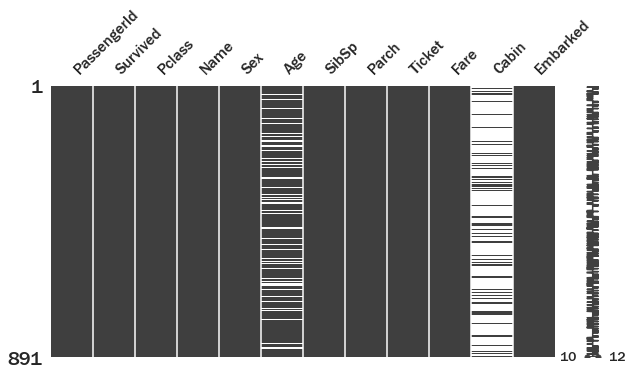

In [103]:
msno.matrix(train, figsize=(10,5))
plt.show()

- `Cabin` has missing data for around 77% of the rows, this could cause bais in the model so we will drop this column
- `Age` column has 20% missing data, we will replace missing values with `mean` or 'median` depending upon the distribution of data
- `Embarked` has missing data for 2 rows, we will drop these 2 rows

In [50]:
# drop the Cabin column from the dataset
train.drop(columns=['Cabin'], inplace=True)

In [51]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S


In [52]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [53]:
train.drop(index=[61, 829], axis=0, inplace=True)

In [54]:
train['Embarked'].value_counts(ascending=False)

S    644
C    168
Q     77
Name: Embarked, dtype: int64

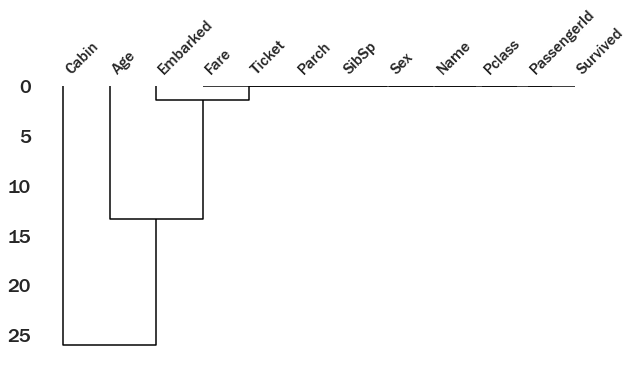

In [104]:
msno.dendrogram(train, figsize=(10,5))
plt.show()

### Univariate Analysis

In [55]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

<AxesSubplot:ylabel='Survived'>

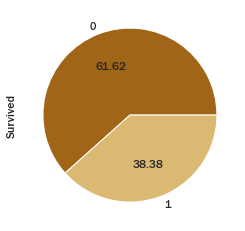

In [150]:
train['Survived'].value_counts(normalize=True).plot(kind='pie', 
                                                    autopct='%.2f', 
                                                    labels=train.index,
                                                   )

Out of 891 passengers, only 38% survived, while majority 61% the passenger did not survive the disaster.

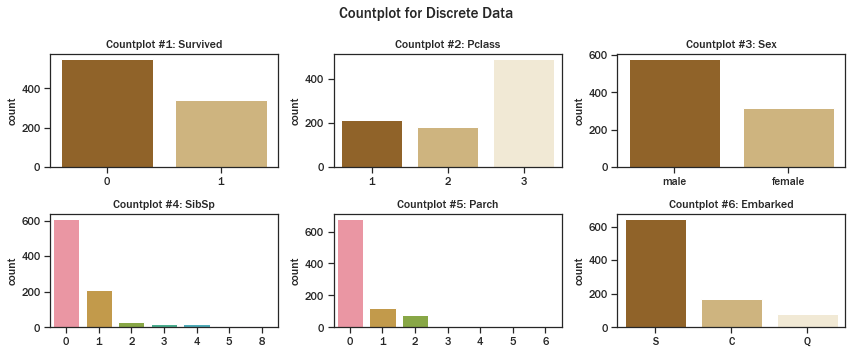

In [151]:
col_names = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
sub_count = 1

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,5))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Countplot for Discrete Data', fontsize=15, fontweight=200)

for ax, feature in zip(axes.flatten(), train[col_names].columns):
    ax.set(title='Countplot #{}: {}'.format(sub_count, feature))
    ax.xaxis.label.set_visible(False)
    sns.countplot(train[feature],ax=ax)
    sub_count += 1

plt.tight_layout()
plt.show()

💡 Tip: In case we want to create multiple `displot` we won't be able to do so with same for loop method as above, why?
- [Difference between displot vs histplot](https://stackoverflow.com/a/63895570/8390360)
- [How to create multiple displot in same figure](https://stackoverflow.com/a/63974061/8390360)

<Figure size 576x360 with 0 Axes>

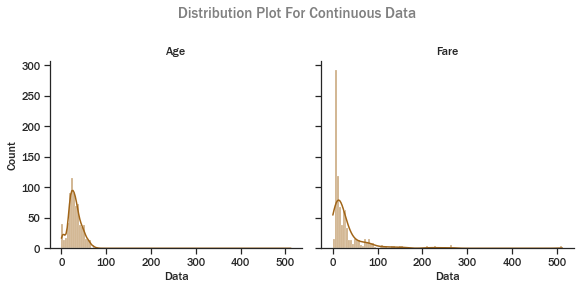

In [152]:
# select columns for which plot has to be created
train_age_fare_dis = train[['Age', 'Fare']]

# now stack the data into a long (tidy) format
train_age_fare_dis = train_age_fare_dis.stack().reset_index(level=1).rename(columns={'level_1':'Column', 0:'Data'})

# plot a displot
fig = plt.figure(figsize=(8, 5))
g = sns.displot(data=train_age_fare_dis, x='Data', col='Column', col_wrap=3, kde=True, height=4)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.suptitle('Distribution Plot For Continuous Data', x=0.35, y=1, fontsize=15, fontweight=200, color='grey')
plt.tight_layout()
plt.show()

Let's check the count of values for both `Age` and `Fare` greater than 100.

💡 Tip: `value_counts()` is a Series method as doesn't apply on DataFrame. If we have to apply it on DataFrame then we have to first flatten() the DataFrame and then use `pd.value_counts(flattened DataFrae)` method. 

In [58]:
pd.value_counts(train[train['Age'] > 100]['Age'].values.flatten()).sum()

0

In [59]:
pd.value_counts(train[train['Fare'] > 100]['Fare'].values.flatten()).sum()

53

- Column `Age` doesn't have any value greater than 100 which also make sense because usually humans live less than 100 years.
- Column 'Fare` has 6% values which are greater than 100, but very less

So we will add filter to our `displot` data for `Age` and `Fare` and will only consider values < 101

<Figure size 432x288 with 0 Axes>

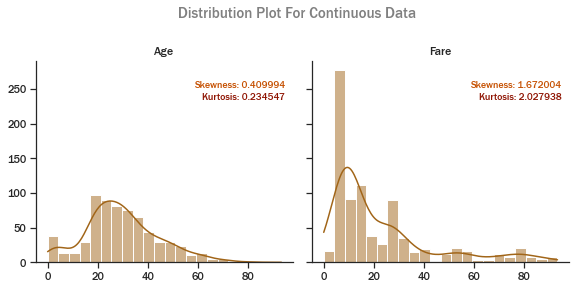

In [153]:
# select columns for which plot has to be created
train_age_fare_dis = train[train['Fare'] < 101][['Age', 'Fare']]

# now stack the data into a long (tidy) format
train_age_fare_dis = train_age_fare_dis.stack().reset_index(level=1).rename(columns={'level_1':'Column', 0:'Data'})

# add function for skewnewss and kurtosis annotation for each plot in facet grid
def annotate_skew_kurt(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(x=0.97, y=0.90, transform=ax.transAxes, s="Skewness: %f" % data.skew(),
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',
        backgroundcolor='white', color='xkcd:dark orange')
    ax.text(x=0.97, y=0.84, transform=ax.transAxes, s="Kurtosis: %f" % data.kurt(),
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',
        backgroundcolor='white', color='xkcd:brick red')

# plot a displot
fig = plt.figure()
g = sns.displot(data=train_age_fare_dis, x='Data', col='Column', col_wrap=3, kde=True, height=4)
g.map_dataframe(annotate_skew_kurt)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.suptitle('Distribution Plot For Continuous Data', x=0.35, y=1, fontsize=15, fontweight=200, color='grey')
plt.tight_layout()
plt.show()

Based on skewness and kurtosis values for `Age` column we can say that data is faily normally distributed while for `Fare` column we can say data is highly positvely skwed and also has moderate presensce of outliers as kurtosis is close 

Let's make boxplot for both `Age` and `Fare` columns.

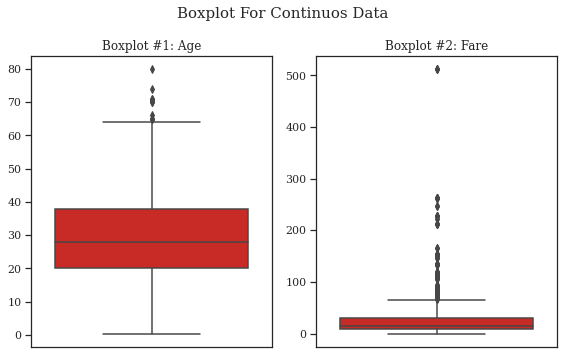

In [456]:
col_names = ['Age', 'Fare']
sub_count = 1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
fig.subplots_adjust(hspace=0.8)
fig.suptitle('Boxplot For Continuos Data', fontsize=15, fontweight=200)

for ax, feature in zip(axes.flatten(), train[col_names].columns):
    ax.set(title='Boxplot #{}: {}'.format(sub_count, feature))
    ax.yaxis.label.set_visible(False)
    ax.tick_params(axis='x', which='both', length=0)
    sns.boxplot(y=train[feature],ax=ax, color='#e3120b')
    sub_count += 1

plt.tight_layout()
plt.show()

Colunm `Fare` has a big outlier in the dataset, let's check the outlier row and see if we shoukd drop it from the dataframe.

In [65]:
train.sort_values(by='Fare', ascending=False).head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,S


The outliers are actually not because of any error or sampling process, these are price of tickets which means they may have relation with other data in the dataset so we will keep these outliers.

### Bi-variate Analysis

Find the correlation between two features using corr() and heatmap() functions.

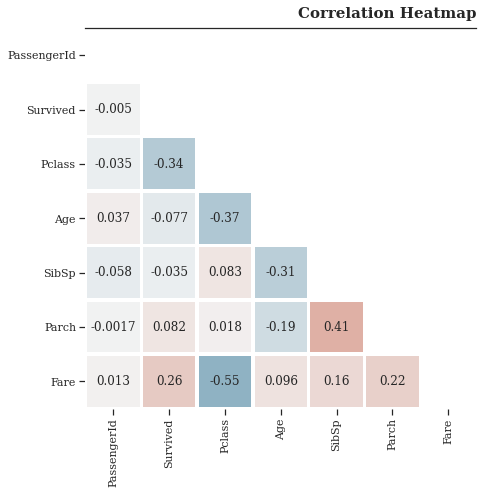

In [186]:
# create correlation matrix 
corr = train.corr()

# create figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

# define mask to hide the upper triangle of the heatmap 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# define cmap for color mapping
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# rotate x axis ticks to 90 deg and y axis to 0 degree, set font size to 11 px
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=11)
ax.set_yticklabels(ax.get_xticklabels(), rotation = 0, fontsize=11)

# create heatmap plot
g = sns.heatmap(corr, 
                mask=mask,
                vmin=-1, vmax=1,
                linewidth=2.5,
                annot=True,
                cmap=cmap,
                cbar=False,
                ax=ax)

# make top border of the heatmap visible
ax.spines['top'].set_visible(True)

# add text to figure as title of the heatmap [ can also use set_title() method ]
fig.text(0.9, 0.9, 'Correlation Heatmap', fontweight='bold', fontfamily='serif', fontsize=15, ha='right')

plt.show()

From Correlation heatmap it is evident that: 
- `Fare` and `Survived` are positively correlated.
- There is positive correlation between `Parch` and `SibSp`
- There is negative correlation between `Fare` and `Pclass`

What does positive and negative correlation means?
- **Positive Correlation:** This occurs when the value of one variable increases then the value of the other variable(s) also increases.
- **Negative Correlation:** This occurs when the value of one variable increases and the value of other variable(s) decreases.

Let's look deeper into survival rate and its relationship with other feature.
1. Find survival rate based on `sex`
2. Find survival rate based on `age band` -> create age band

In [195]:
survival_rate = pd.DataFrame(train.groupby('Sex').mean()['Survived'])
male_rate = survival_rate.loc['male']
female_rate = survival_rate.loc['female']

In [223]:
"""
np.random.uniform() generates random samples from uniform distribution and returns the random samples as numpy array.

Parameters for this method are low=0.0, high=1.0, size=None
"""

male_pos = np.random.uniform(0, male_rate, len(train[(train['Sex'] == 'male') & (train['Survived'] == 1)]))
male_neg = np.random.uniform(male_rate, 1, len(train[(train['Sex'] == 'male') & (train['Survived'] == 0)]))
female_pos = np.random.uniform(0, female_rate, len(train[(train['Sex'] == 'male') & (train['Survived'] == 1)]))
female_neg = np.random.uniform(female_rate, 1, len(train[(train['Sex'] == 'male') & (train['Survived'] == 0)]))

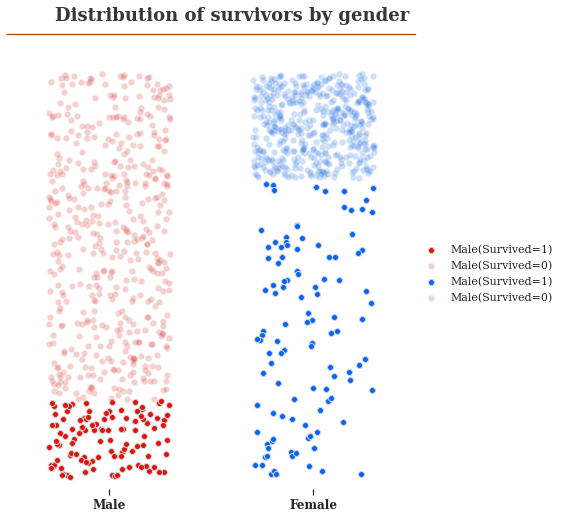

In [453]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

np.random.seed(42)

# Male Stripplot
ax.scatter(np.random.uniform(-0.3, 0.3, len(male_pos)), male_pos, color='#e3120b', edgecolor='lightgray', label='Male(Survived=1)')
ax.scatter(np.random.uniform(-0.3, 0.3, len(male_neg)), male_neg, color='#e3120b', edgecolor='lightgray', alpha=0.2, label='Male(Survived=0)')

# Female Stripplot
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(female_pos)), female_pos, color='xkcd:bright blue', edgecolor='lightgray', label='Male(Survived=1)')
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(female_neg)), female_neg, color='xkcd:bright blue', edgecolor='lightgray', alpha=0.2, label='Male(Survived=0)')

# Set Figure & Axes
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.03, 1.1)

# Ticks
ax.set_xticks([0, 1])
ax.set_xticklabels(['Male', 'Female'], fontweight='bold', fontsize=12)
ax.set_yticks([], minor=False)
ax.set_ylabel('')

# remove figure borders
for s in ["right","left", 'bottom']:
    ax.spines[s].set_visible(False)

ax.spines['top'].set_color('xkcd:rust')
    
# Title & Explanation
fig.text(0.72, 1, 'Distribution of survivors by gender', fontweight='bold', fontsize=18, color='xkcd:dark grey', ha = 'right')

ax.legend(loc=(1, 0.4), edgecolor='None')
plt.tight_layout()
plt.show()

In [262]:
# define funcction for converting age into age band
def age_band(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

In [263]:
# add column in train dataframe for age_band
train['age_band'] = train['Age'].apply(age_band)
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,20 ~ 30
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30 ~ 40
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,20 ~ 30
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30 ~ 40
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30 ~ 40


In [277]:
titanic_age = train[['age_band', 'Survived']].groupby('age_band')['Survived'].value_counts().sort_index().unstack().fillna(0)
titanic_age['Survival rate'] = titanic_age[1] / (titanic_age[0] + titanic_age[1]) * 100
titanic_age

Survived,0,1,Survival rate
age_band,,,
0 ~ 10,24.0,38.0,61.290323
10 ~ 20,61.0,41.0,40.196078
20 ~ 30,143.0,77.0,35.000000
30 ~ 40,94.0,73.0,43.712575
40 ~ 50,55.0,34.0,38.202247
50 ~ 60,28.0,20.0,41.666667
60 ~ 70,13.0,6.0,31.578947
70 ~ 80,6.0,0.0,0.000000
80 ~ 90,0.0,1.0,100.000000


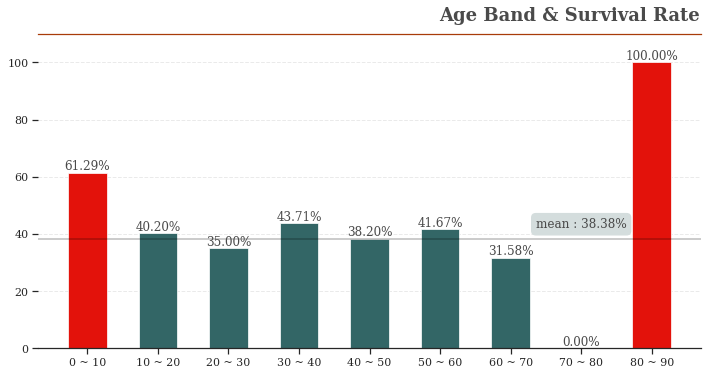

In [422]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.subplots_adjust(top=0.8)

color_map = ['#336666' for _ in range(9)]
color_map[0] = color_map[8] = '#e3120b' # color highlight

ax.bar(titanic_age['Survival rate'].index, titanic_age['Survival rate'], 
       color=color_map, width=0.55, 
#        edgecolor='black', 
       linewidth=0.7)
ax.set_ylim(0, 110)

for s in ["right","left"]:
    ax.spines[s].set_visible(False)

ax.spines['top'].set_color('xkcd:rust')

# Annotation Part
for i in titanic_age['Survival rate'].index:
    ax.annotate(f"{titanic_age['Survival rate'][i]:.02f}%", 
                   xy=(i, titanic_age['Survival rate'][i] + 2.3),
                   va = 'center', ha='center',fontweight='light', 
                   color='#4a4a4a')

# mean line + annotation
mean = train['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='-')
ax.annotate(f"mean : {mean :.4}%", 
            xy=('70 ~ 80', mean + 5),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#d4dddd', linewidth=0))
    

# Title & Subtitle    
fig.text(0.98, 1, 'Age Band & Survival Rate', fontsize=18, fontweight='bold', color='#4a4a4a', ha='right')

grid_y_ticks = np.arange(0, 101, 20)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [354]:
survival_rate = train.groupby(['Pclass']).mean()[['Survived']]
p1_rate = survival_rate.loc[1]
p2_rate = survival_rate.loc[2]
p3_rate = survival_rate.loc[3]

p1_pos = np.random.uniform(0, p1_rate, len(train[(train['Pclass']==1) & (train['Survived']==1)]))
p1_neg = np.random.uniform(p1_rate, 1, len(train[(train['Pclass']==1) & (train['Survived']==0)]))
p2_pos = np.random.uniform(0, p2_rate, len(train[(train['Pclass']==2) & (train['Survived']==1)]))
p2_neg = np.random.uniform(p2_rate, 1, len(train[(train['Pclass']==2) & (train['Survived']==0)]))
p3_pos = np.random.uniform(0, p3_rate, len(train[(train['Pclass']==3) & (train['Survived']==1)]))
p3_neg = np.random.uniform(p3_rate, 1, len(train[(train['Pclass']==3) & (train['Survived']==0)]))

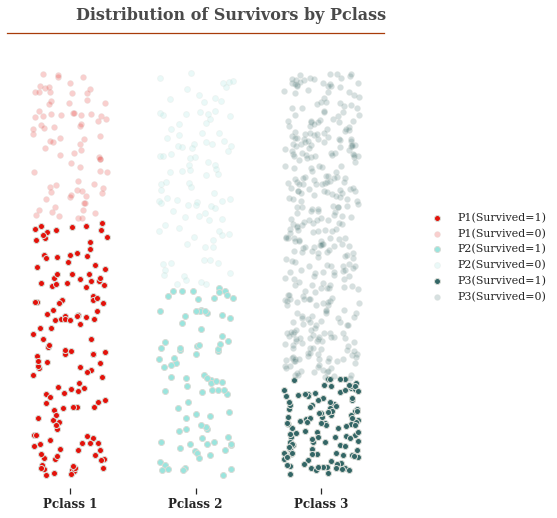

In [457]:
# create an empty figure
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

# define random seed amount
np.random.seed(42)

# Pclass = 1 striplot
ax.scatter(np.random.uniform(-0.3, 0.3, len(p1_pos)), p1_pos, color='#e3120b', edgecolors='xkcd:light grey', label='P1(Survived=1)')
ax.scatter(np.random.uniform(-0.3, 0.3, len(p1_neg)), p1_neg, color='#e3120b', edgecolors='xkcd:light grey', alpha=0.2, label='P1(Survived=0)')

# Pclass = 2 striplot
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(p2_pos)), p2_pos, color='#9ae5de', edgecolors='xkcd:light grey', label='P2(Survived=1)')
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(p2_neg)), p2_neg, color='#9ae5de', edgecolors='xkcd:light grey', alpha=0.2, label='P2(Survived=0)')

# Pclass = 3 striplot
ax.scatter(2+np.random.uniform(-0.3, 0.3, len(p3_pos)), p3_pos, color='#336666', edgecolors='xkcd:light grey', label='P3(Survived=1)')
ax.scatter(2+np.random.uniform(-0.3, 0.3, len(p3_neg)), p3_neg, color='#336666', edgecolors='xkcd:light grey', alpha=0.2, label='P3(Survived=0)')

# Set axis limit
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.03, 1.1)

# set axis ticks and labels
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Pclass 1', 'Pclass 2', 'Pclass 3'], fontsize=12, fontweight='bold')
ax.yaxis.label.set_visible(False)
ax.set_yticks([])
ax.set_yticklabels('')

# set axis spines
for s in ['right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)
    
ax.spines['top'].set_color('xkcd:rust')

# set figure title
fig.text(0.68, 1, 'Distribution of Survivors by Pclass', fontsize=16, fontweight='bold', color='#4a4a4a', ha='right')

ax.legend(loc=(1.1, 0.4), edgecolor='None')
plt.tight_layout()
plt.show()